In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
# Load BloodMNIST dataset
from medmnist import BloodMNIST

basic_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

train_dataset = BloodMNIST(split="train", transform=basic_transforms, download=True, size=28)
test_dataset = BloodMNIST(split="test", transform=basic_transforms, download=True, size=28)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
# information about the train_dataset
train_dataset

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\pande\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    Lice

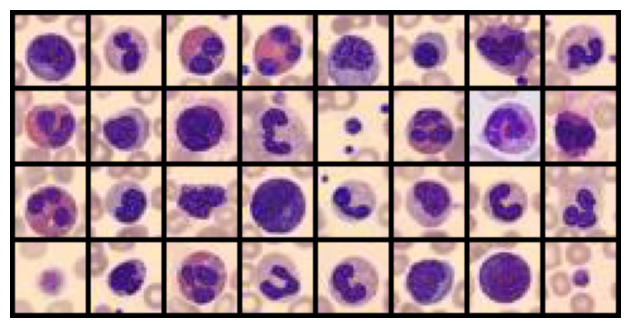

In [11]:
# visualise data
import torchvision.utils as vutils

# Get a batch of training images
images, labels = next(iter(train_loader))

# Create a grid of images
img_grid = vutils.make_grid(images[:32], nrow=8, normalize=True)

# Display the grid
plt.figure(figsize=(8, 4))
plt.imshow(img_grid.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.axis("off")
plt.show()


In [12]:
# Define data transformations
# basic_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_data_loaders(batch_size=64):
    """Downloads and prepares the BloodMNIST dataloaders."""
    train_dataset = BloodMNIST(split="train", transform=basic_transforms, download=True, size=28)
    test_dataset = BloodMNIST(split="test", transform=basic_transforms, download=True, size=28)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs):
    """A complete function to train and evaluate a given model."""
    model.to(device)
    
    # Training loop
    for epoch in range(epochs):
        model.train() # Set model to training mode
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.view(-1))
            loss.backward()
            optimizer.step()
            
            loop.set_postfix(loss=loss.item())

    # Evaluation
    model.eval() # Set model to evaluation mode
    labels_list = []
    preds_list = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(dim=1)
            labels_list.extend(labels.cpu().numpy())
            preds_list.extend(preds.cpu().numpy())
            
    print("\n--- Classification Report ---")
    print(classification_report(y_true=labels_list, y_pred=preds_list))
    print("-" * 55 + "\n")

In [13]:
def run_baseline_model():
    """Replicates the original notebook's model and training."""
    print("Running Experiment: Baseline Model...")
    
    class MLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3 * 28 * 28, 256), nn.ReLU(),
                nn.Linear(256, 128), nn.ReLU(),
                nn.Linear(128, 8)
            )
        def forward(self, x):
            return self.layers(x)

    train_loader, test_loader = get_data_loaders()
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=5)
run_baseline_model()

Running Experiment: Baseline Model...


Epoch 5/5: 100%|██████████| 187/187 [00:02<00:00, 73.95it/s, loss=0.898]



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.52      0.51      0.52       244
           1       0.75      0.82      0.79       624
           2       0.84      0.56      0.67       311
           3       0.52      0.55      0.53       579
           4       0.67      0.72      0.69       243
           5       0.54      0.22      0.31       284
           6       0.72      0.90      0.80       666
           7       0.96      0.97      0.97       470

    accuracy                           0.71      3421
   macro avg       0.69      0.66      0.66      3421
weighted avg       0.70      0.71      0.69      3421

-------------------------------------------------------



In [14]:
def run_deeper_model():
    """Trains a deeper MLP by adding more hidden layers."""
    print("Running Experiment 1: Deeper Model (Increased Hidden Layers)...")

    class DeeperMLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3 * 28 * 28, 256), nn.ReLU(),
                nn.Linear(256, 128), nn.ReLU(),
                nn.Linear(128, 64), nn.ReLU(),  # Additional layer
                nn.Linear(64, 32), nn.ReLU(),   # Additional layer
                nn.Linear(32, 8)
            )
        def forward(self, x):
            return self.layers(x)

    train_loader, test_loader = get_data_loaders()
    model = DeeperMLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=5)

run_deeper_model()

Running Experiment 1: Deeper Model (Increased Hidden Layers)...


Epoch 5/5: 100%|██████████| 187/187 [00:02<00:00, 68.81it/s, loss=1.16]



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       244
           1       0.44      0.81      0.57       624
           2       0.58      0.53      0.55       311
           3       0.41      0.37      0.39       579
           4       0.00      0.00      0.00       243
           5       0.00      0.00      0.00       284
           6       0.56      0.79      0.66       666
           7       0.88      0.99      0.93       470

    accuracy                           0.55      3421
   macro avg       0.36      0.44      0.39      3421
weighted avg       0.43      0.55      0.48      3421

-------------------------------------------------------



x:\Edu\7th Sem\Neural Networks\(Lab) Neural Networks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Edu\7th Sem\Neural Networks\(Lab) Neural Networks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Edu\7th Sem\Neural Networks\(Lab) Neural Networks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [15]:
def run_tanh_activation_model():
    """Trains an MLP using Tanh as the activation function instead of ReLU."""
    print("Running Experiment 2: Changed Activation Function (Tanh)...")

    class MLPWithTanh(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3 * 28 * 28, 256), nn.Tanh(), # Changed to Tanh
                nn.Linear(256, 128), nn.Tanh(),      # Changed to Tanh
                nn.Linear(128, 8)
            )
        def forward(self, x):
            return self.layers(x)

    train_loader, test_loader = get_data_loaders()
    model = MLPWithTanh()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=5)
run_tanh_activation_model()

Running Experiment 2: Changed Activation Function (Tanh)...


Epoch 5/5: 100%|██████████| 187/187 [00:02<00:00, 75.52it/s, loss=0.847]



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.65      0.31      0.42       244
           1       0.78      0.83      0.80       624
           2       0.81      0.66      0.73       311
           3       0.49      0.62      0.55       579
           4       0.71      0.67      0.69       243
           5       0.57      0.20      0.30       284
           6       0.73      0.91      0.81       666
           7       0.95      0.99      0.97       470

    accuracy                           0.72      3421
   macro avg       0.71      0.65      0.66      3421
weighted avg       0.72      0.72      0.70      3421

-------------------------------------------------------



In [16]:
def run_more_epochs():
    """Trains the original baseline model for more epochs."""
    print("Running Experiment 3: Increased Epochs (15 Epochs)...")
    
    # Re-using the baseline MLP class
    class MLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3 * 28 * 28, 256), nn.ReLU(),
                nn.Linear(256, 128), nn.ReLU(),
                nn.Linear(128, 8)
            )
        def forward(self, x):
            return self.layers(x)

    train_loader, test_loader = get_data_loaders()
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=15)
run_more_epochs()

Running Experiment 3: Increased Epochs (15 Epochs)...


Epoch 15/15: 100%|██████████| 187/187 [00:02<00:00, 69.30it/s, loss=0.527]



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       244
           1       0.87      0.96      0.91       624
           2       0.83      0.76      0.79       311
           3       0.60      0.68      0.64       579
           4       0.82      0.71      0.76       243
           5       0.71      0.48      0.57       284
           6       0.87      0.88      0.87       666
           7       0.98      0.98      0.98       470

    accuracy                           0.80      3421
   macro avg       0.79      0.76      0.77      3421
weighted avg       0.80      0.80      0.80      3421

-------------------------------------------------------



In [17]:
def run_adam_optimizer():
    """Trains the baseline model with the Adam optimizer."""
    print("Running Experiment 4: Using a Different Optimizer (Adam)...")

    # Re-using the baseline MLP class
    class MLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3 * 28 * 28, 256), nn.ReLU(),
                nn.Linear(256, 128), nn.ReLU(),
                nn.Linear(128, 8)
            )
        def forward(self, x):
            return self.layers(x)

    train_loader, test_loader = get_data_loaders()
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    # Using Adam with a smaller learning rate
    optimizer = optim.Adam(model.parameters(), lr=0.001) 

    train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=5)
run_adam_optimizer()

Running Experiment 4: Using a Different Optimizer (Adam)...


Epoch 5/5: 100%|██████████| 187/187 [00:02<00:00, 67.08it/s, loss=0.493]



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.70      0.58      0.64       244
           1       0.94      0.94      0.94       624
           2       0.78      0.88      0.83       311
           3       0.73      0.54      0.62       579
           4       0.78      0.79      0.79       243
           5       0.56      0.81      0.66       284
           6       0.88      0.91      0.89       666
           7       0.99      0.96      0.98       470

    accuracy                           0.82      3421
   macro avg       0.80      0.80      0.79      3421
weighted avg       0.83      0.82      0.82      3421

-------------------------------------------------------



In [18]:
def run_regularized_model():
    """Trains an MLP with Batch Normalization and Dropout."""
    print("Running Experiment 5: Using Normalization and Dropout...")

    class MLPWithRegularization(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(3 * 28 * 28, 256),
                nn.BatchNorm1d(256), # Batch Norm added
                nn.ReLU(),
                nn.Dropout(0.5),      # Dropout added (50% probability)
                nn.Linear(256, 128),
                nn.BatchNorm1d(128), # Batch Norm added
                nn.ReLU(),
                nn.Dropout(0.5),      # Dropout added (50% probability)
                nn.Linear(128, 8)
            )
        def forward(self, x):
            return self.layers(x)

    train_loader, test_loader = get_data_loaders()
    model = MLPWithRegularization()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=5)
run_regularized_model()

Running Experiment 5: Using Normalization and Dropout...


Epoch 5/5: 100%|██████████| 187/187 [00:02<00:00, 67.14it/s, loss=0.713]



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.57      0.64      0.61       244
           1       0.94      0.95      0.94       624
           2       0.86      0.74      0.79       311
           3       0.62      0.61      0.61       579
           4       0.80      0.76      0.78       243
           5       0.65      0.53      0.58       284
           6       0.85      0.92      0.89       666
           7       0.96      1.00      0.98       470

    accuracy                           0.80      3421
   macro avg       0.78      0.77      0.77      3421
weighted avg       0.80      0.80      0.80      3421

-------------------------------------------------------

